In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
import pickle
import pandas as pd
import glob
import os
from pprint import pprint
from datetime import datetime
from progressbar import ProgressBar, Bar, Percentage
from ipywidgets import IntProgress
from IPython.display import display
from scipy import signal

setting up global constants

In [2]:
maxRange = 25
chirpDur = 125
c0 = speed_of_light
switchPer = 625e-6
modF = 1 / (2 * switchPer)
modDuty = 50
fs = 1.0e6

define templates

In [3]:
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) > 0:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    return Win

load name of files under /Data directory

In [4]:
dir = '/Users/Anant/MMetroDEnv/PythonCodev2/Data/'
names = [x for x in glob.glob(dir + '*ryu_motion3-24GHz.pickle')]
names.sort()
pprint(names)

['/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-140854-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141102-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141154-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141246-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141341-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141537-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141733-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141830-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141931-ryu_motion3-24GHz.pickle']


In [5]:
def get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel):
    '''========================= setting config information ============================='''
    frmMeasSiz = cfg['FrmMeasSiz']
    N = cfg['N']
    TRampUp = cfg['TRampUp']   
    kf = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']
    vRange = np.arange(nFFT) / nFFT * fs * c0 / (2*kf)
    fc = (cfg['fStop'] + cfg['fStrt']) / 2
    
    RMin = 5
    RMax = min(maxRange, (N / TRampUp) * c0 / (4 * 250e6 / TRampUp))
    RMinIdx = np.argmin(np.abs(vRange - RMin))
    RMaxIdx = np.argmin(np.abs(vRange - RMax))
    vRangeExt = vRange[RMinIdx:RMaxIdx]
    
    # reshape the data
    data = np.reshape(data_snapshot, (N, frmMeasSiz), order='F')
    data = data - data[:,0][:,None]

    
    '''================================ getting RP ====================================='''
    # hanning window used for getting RP
    Win2D = hanning(N, int(frmMeasSiz))
    ScaWin = sum(Win2D[:, 0])
    
    RP = 2 * np.fft.fft(np.multiply(data, Win2D), n=nFFT, axis=0) / ScaWin * 0.498 / 65536
    
    '''================================= getting RD ====================================='''
    # hanning window used for getting RD
    WinVel2D = hanning(int(frmMeasSiz), len(vRangeExt))
    ScaWinVel = sum(WinVel2D[:, 0])
    WinVel2D = WinVel2D.transpose()
    
    # getting RD
    RPExt = RP[RMinIdx:RMaxIdx, :]
    RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nFFT_vel, axis=1) / ScaWinVel
    
    return RPExt, RD, vRangeExt
    

def plot_doppler(file_name, frame_idx, save_fig = False, save_RD_norm = False, save_dir = 'Data/'):
    # load data from file name
    file = open(file_name, 'rb')
    data_raw = pickle.load(file)
    file.close()
    
    # get singe channel raw data and its config
    data_single_chn = data_raw['Data'][:,:,0] # select one channel (antena)
    data_snapshot = data_single_chn[:,frame_idx]
    cfg = data_raw['Cfg']
 
    # get RP and RD
    nFFT = 2**10
    nFFT_vel = 2**8
    RPExt, RD, vRangeExt = get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel)
    
    # normalize RD for plotting
    RD = RD[:,30:-30]
    RD_diff = np.abs(RD) - np.min(np.abs(RD))
    RD_norm = RD_diff / np.max(np.abs(RD))
    
    # Get information for plotting
    fc = (cfg['fStop'] + cfg['fStrt']) / 2
    vFreqVel = np.arange(-nFFT_vel//2, nFFT_vel//2)/nFFT_vel*(1/cfg['Perd'])
    vVel = (vFreqVel*c0/(2*fc))[10:-10]
    
    vRangeExtVisIdx = np.arange(0, vRangeExt.shape[0], 20)
    vRangeExtVis = list(map(lambda x: "%.2f" % x, vRangeExt[vRangeExtVisIdx]))
    vVelVisIdx = np.arange(0, vVel.shape[0], 50)
    vVelVis = list(map(lambda x: "%.2f" % x, vVel[vVelVisIdx]))
    chirpVisIdx = np.arange(0, cfg["FrmMeasSiz"], 50)
    
    # plotting RP and RD
    fig, axes = plt.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    axes[0].imshow(np.abs(RPExt), aspect='auto')
    axes[0].set_title("Range Profile")
    axes[0].set_xticks(chirpVisIdx)
    axes[0].set_xlabel("Chirps")
    axes[0].set_yticks(vRangeExtVisIdx, labels=vRangeExtVis)
    axes[0].set_ylabel("Range (m)")

    axes[1].imshow(np.abs(RD), aspect='auto')
    axes[1].set_title("Doppler Profile")
    axes[1].set_xticks(vVelVisIdx, labels=vVelVis)
    axes[1].set_xlabel("Vel Bins")
    axes[1].set_yticks(vRangeExtVisIdx, labels=vRangeExtVis)
    axes[1].set_ylabel("Range (m)")
    
    # save figure/data setting
    if save_fig:
        path = save_dir + file_name[28:-7] + '/image'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(path + '/frame_'+str(frame_idx)+'.png')
    if save_RD_norm:
        path = save_dir + file_name[28:-7] + '/RD_norm'
        if not os.path.exists(path):
            os.makedirs(path)
        np.save(path+'/frame_' + str(frame_idx) + '.npy', RD_norm)
        
    plt.show()

In [6]:
def sincTemplate(cfg, modF, modDuty, NFFTVel, vel):
    fc = (cfg['fStop'] + cfg['fStrt']) / 2
    c0 = 2.998e8
    t = np.linspace(0, cfg['Perd']*200, 200)
    doppShift = np.fft.fft(np.cos(2*np.pi*(2*vel*fc/c0*t)), n=NFFTVel, axis=0)
    undopp_square = np.fft.fft(sp.signal.square(2*np.pi*modF*t, modDuty/100), n=NFFTVel, axis=0)
    if vel > 0:
        doppShift[int(NFFTVel/2):] = 0
        sq_wav = np.convolve(doppShift, undopp_square)
        to_return = np.abs(sq_wav[:NFFTVel])
    elif vel<0:
        doppShift[int(NFFTVel/2):] = 0
        doppShift = np.flip(doppShift)
        sq_wav = np.convolve(doppShift, undopp_square)
        to_return = np.abs(sq_wav[NFFTVel-1:])
    else:
        to_return = np.abs(undopp_square)
    to_return = to_return / np.max(to_return)
    to_return[to_return<0.1] = 0
    return to_return

def create_template(vel_list, cfg, NFFTVel):
    templateAll = np.zeros((len(vel_list), NFFTVel-60))
    for vIdx in range(len(vel_list)):
        template = sincTemplate(cfg, modF, modDuty, NFFTVel, vel_list[vIdx])
        templateAll[vIdx] = template[30:-30]
    return templateAll
    
def get_position(RD_norm, templateAll, vRangeExt):
    max_max_corr = 0
    max_idx = 0
    for i in range(len(templateAll)):
        template = templateAll[i]
        corr = np.abs(RD_norm) * np.repeat(np.abs(template[:, np.newaxis]), RD_norm.shape[0], axis = 1).T
        corr_sum = np.sum(np.abs(corr), axis=1)
        max_corr = np.max(corr_sum)
        if max_corr > max_max_corr:
            vel_i = i
            max_max_corr = max_corr
            max_idx = np.argmax(corr_sum)
                                
    range_idx = max_idx
    to_return = vRangeExt[range_idx]
    return to_return, vel_i

def get_timestamps(data_raw):
    date_time_obj = []
    first_timestamp = True
    for i in range(len(data_raw['dtime'])):
        date = data_raw['dtime'][i]
        while(len(date) < 23):
            pre = date[:20]
            post = date[20:]
            date = pre+'0'+post
            
        if first_timestamp:
            time_init = datetime.strptime(date, '%Y-%m-%d %H:%M:%S:%f')
            date_time_obj.append(0)
            first_timestamp = False
        else:
            delta = datetime.strptime(date, '%Y-%m-%d %H:%M:%S:%f') - time_init
            date_time_obj.append(delta.total_seconds()) 
    return date_time_obj

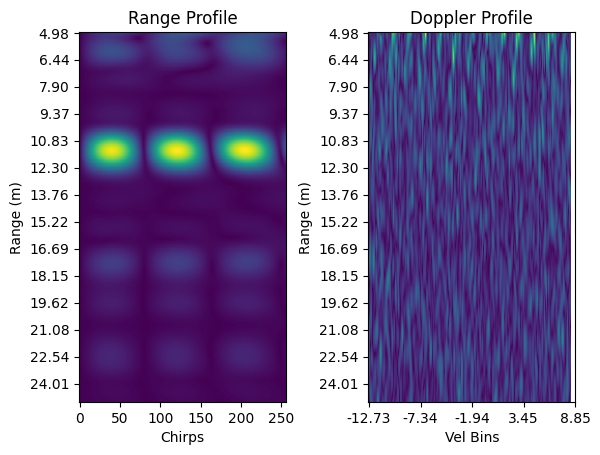

In [7]:
plot_doppler(names[7], 300, save_fig = True, save_RD_norm = True)

In [8]:
def process_plot(names, save=True, save_dir = 'Data/', file_name = None):
    for names_i in range(len(names)):
        file = open(names[names_i], 'rb')
        data_raw = pickle.load(file)
        file.close()
        data_single_chn = data_raw['Data'][:,:,0]
        cfg = data_raw['Cfg']
        n_frame = data_single_chn.shape[1]
        position = np.zeros(n_frame)
        vel = np.zeros(n_frame)
        nFFT = 2**10
        nFFT_vel = 2**8
        
        pprint("start processing " + names[names_i])

        f = IntProgress(min=0, max=n_frame) # instantiate the bar
        display(f)
        for i in range(n_frame):
            data_snapshot = data_single_chn[:,i]
            RPExt, RD, vRangeExt = get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel)
            
            RD = RD[:,30:-30]
            RD_diff = np.abs(RD) - np.min(np.abs(RD))
            RD_norm = RD_diff / np.max(np.abs(RD))
            
            velArr = np.arange(-2,2,0.1)
            templateAll = create_template(velArr, cfg, nFFT_vel)
            
            position[i], vel_i = get_position(RD_norm, templateAll, vRangeExt)
            vel[i] = velArr[vel_i]
            f.value += 1
            
            
        timestamps = get_timestamps(data_raw)
                
        plt.plot(timestamps, position)
        plt.xlabel('time (ms)')
        plt.ylabel('range (m)')
        
        plt.figure()
        plt.plot(timestamps, vel)
        
        
        if save:
            to_save = [timestamps, position]
            to_save_v = [timestamps, vel]
            path = save_dir + names[names_i][28:-7]
            if not os.path.exists(path):
                os.makedirs(path)
            if file_name:
                np.save(path+ '/' + file_name + '_data.npy', to_save)
                plt.savefig(path + '/' + file_name + '_plot.png')
                np.save(path+ '/' + file_name + '_vel_data.npy', to_save_v)
            else:
                np.save(path+ '/processed_range_time.npy', to_save)
                plt.savefig(path + '/range_time_plot.png')
            
        plt.show()

In [9]:
names

['/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-140854-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141102-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141154-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141246-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141341-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141537-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141733-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141830-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141931-ryu_motion3-24GHz.pickle']

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-140854-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=407)

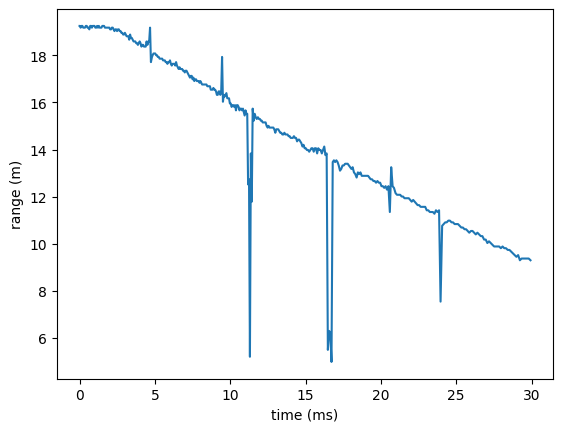

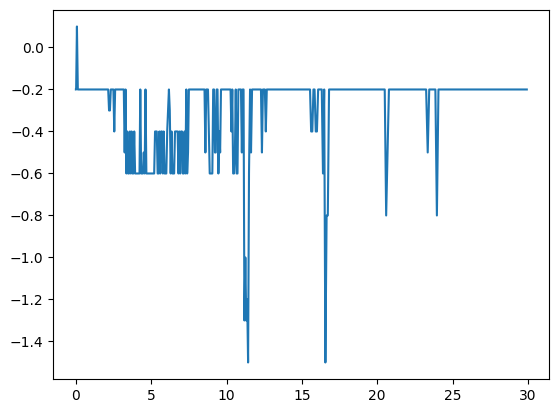

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141102-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=409)

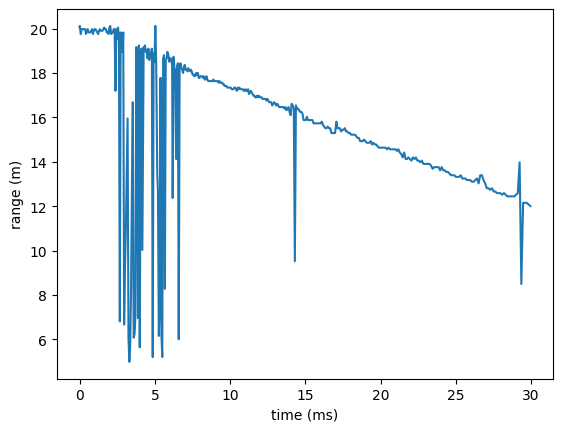

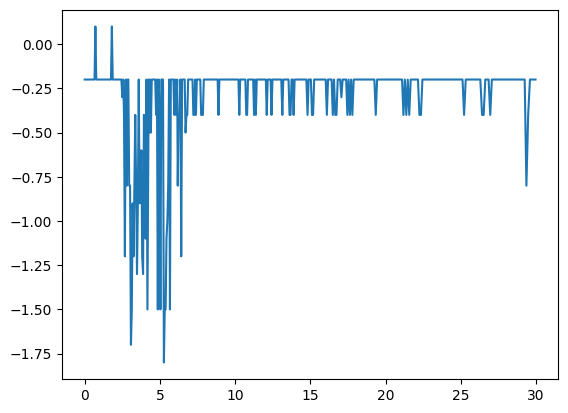

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141154-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=404)

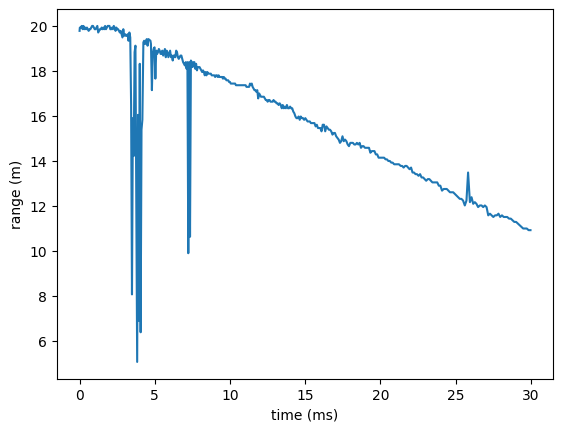

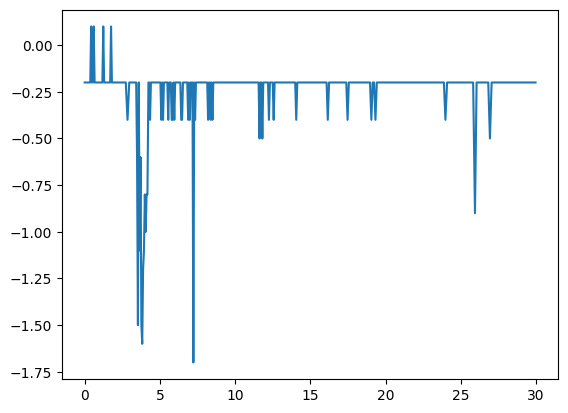

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141246-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=401)

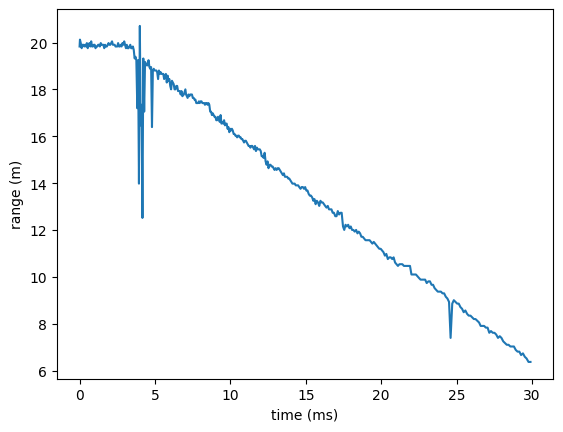

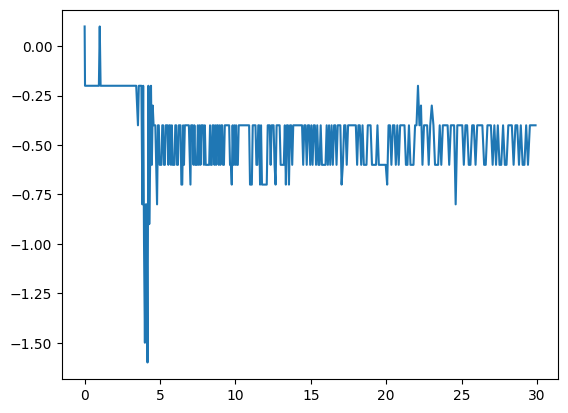

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141341-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=403)

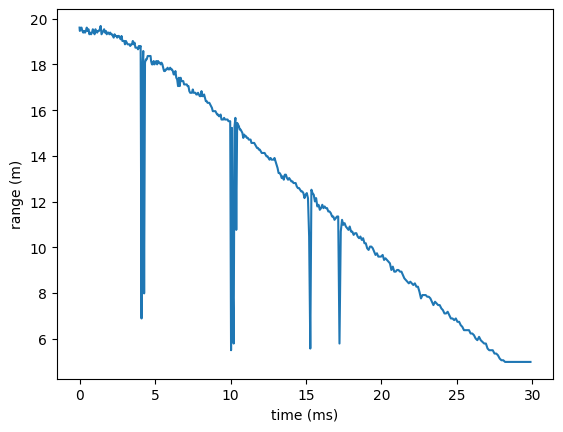

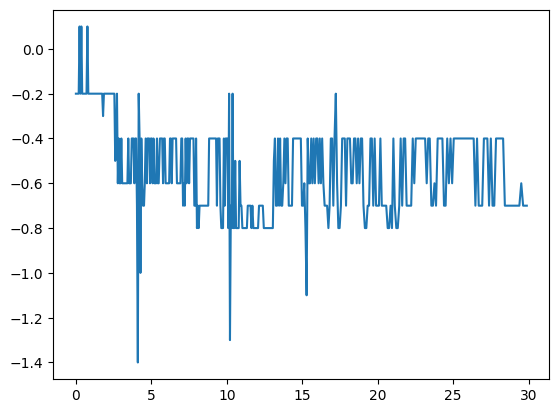

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141537-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=399)

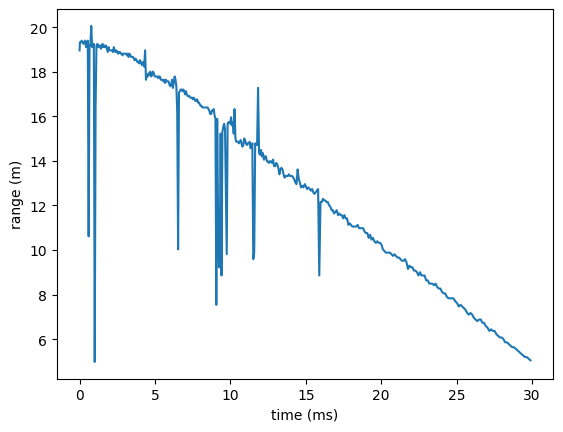

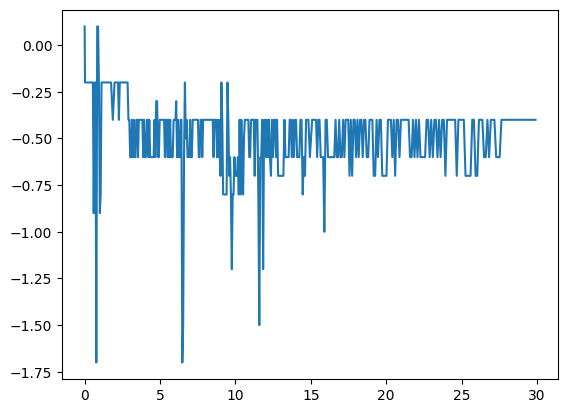

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141733-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=381)

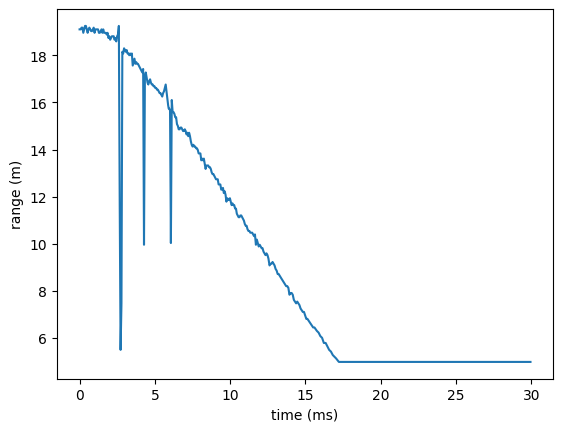

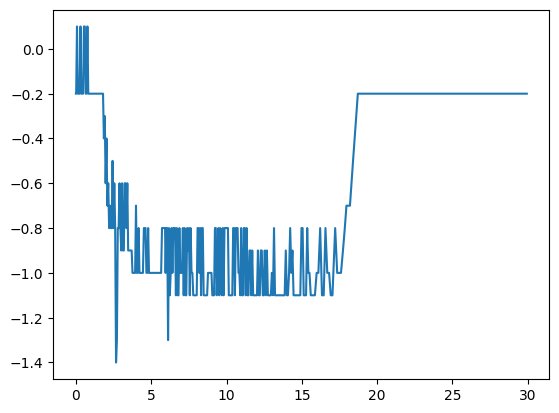

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141830-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=402)

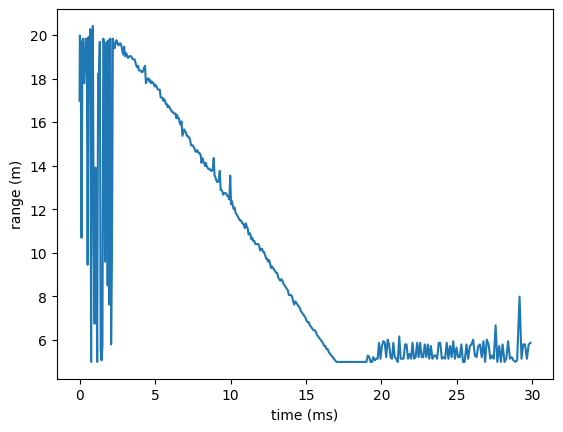

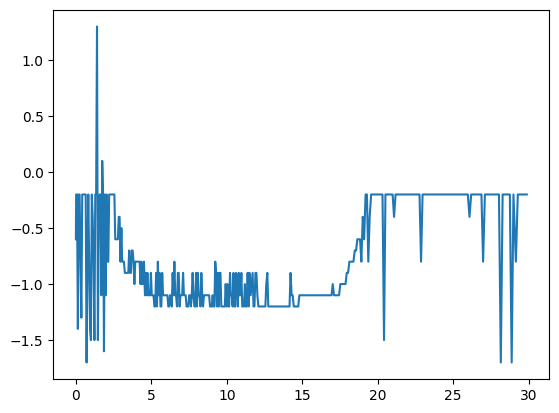

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141931-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=403)

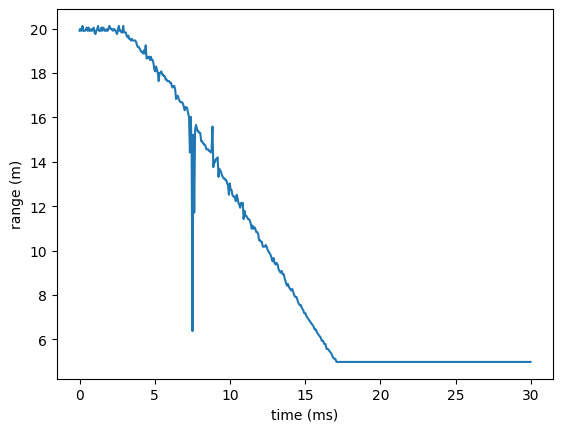

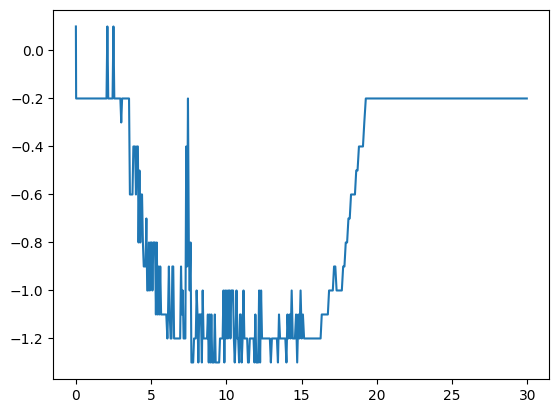

In [10]:
process_plot(names, file_name='high_vel_range')

In [11]:
data = np.load('Data/230213-141733-ryu_motion3-24GHz/high_vel_range_data.npy')
data_v = np.load('Data/230213-141733-ryu_motion3-24GHz/high_vel_range_vel_data.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/230213-141733-ryu_motion3-24GHz/high_vel_range_data.npy'

In [ ]:
timestamp = data[0]
distance = data[1]
timestamp1 = data_v[0]
velocity = data_v[1]

In [ ]:
plt.plot(timestamp, distance)
plt.plot(timestamp1, velocity)
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.legend(['original', 'improved'])

In [ ]:
distance[48]

In [ ]:
plot_doppler(names[6], 48, save_fig = True, save_RD_norm = True)

In [ ]:
# def initialize():
#     x = Z[0]
#     p = 1
#     return x, p

# def predict(x, p, v):
#     # Prediction 
#     x = x + dt*v                    # State Transition Equation (Dynamic Model or Prediction Model)
#     p = p + (dt**2 * p_v) + q       # Predicted Covariance equation
#     return x, p

# def measure():
#     z = Z[i]
#     return z

# def update(x, p, z):
#     k = p / ( p + r)                # Kalman Gain
#     x = x + k * (z - x)             # State Update
#     p = (1 - k) * p                 # Covariance Update
#     return x, p

# def runKalmanFilter():
#     x, p = initialize()

#     for j in range(1, n):
#         x, p = predict(x, p)
#         z = measure()
#         x, p = update(x, p, z) 

In [ ]:
n = len(timestamp)
dt = (timestamp[-1] - timestamp[0]) / n
x = distance[0]
p = 1
v = -1
p_v = 0.1
q = 0.1
r = 0.5

x_to_return = []

x_to_return.append(x)

def predict(x,p, v):
    x = x + dt*v                    # State Transition Equation (Dynamic Model or Prediction Model)
    p = p + (dt**2 * p_v) + q
    return x, p

def update(x, p, z):
    if abs(z - x) > 3:
        r = 20
        print("error")
    else:
        r = 0.5
    k = p / ( p + r)                # Kalman Gain
    x = x + k * (z - x)             # State Update
    p = (1 - k) * p                 # Covariance Update
    return x, p

for i in range(1, n):
    x_, p_ = predict(x, p, velocity[i])
    z = distance[i]
    x, p = update(x_, p_, z)
    x_to_return.append(x)

In [12]:
plt.plot(timestamp, distance)
plt.plot(timestamp, x_to_return)
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.legend(['original', 'with kalman filter'])
plt.title("speed = -1.0m/s")

NameError: name 'timestamp' is not defined

In [ ]:
import scipy
med_x = scipy.signal.medfilt(distance, kernel_size=9)

In [ ]:
plt.plot(timestamp, med_x)

In [ ]:
plt.plot(timestamp, measurement)
plt.plot(timestamp, x_to_return)
plt.plot(timestamp, med_x)
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.legend(['original', 'with kalman filter', 'median_filter'])

In [ ]:
diff = measurement == med_x

In [ ]:
plt.plot(timestamp, measurement, c = 'y')
plt.scatter(timestamp[diff], med_x[diff], s=5, c='r')
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.legend(['original', 'sample taken'])

In [ ]:
data = np.load('Data/230213-141733-ryu_motion3-24GHz/processed_range_time1.npy')
timestamp = data[0]
measurement = data[1]
plt.plot(timestamp, measurement)

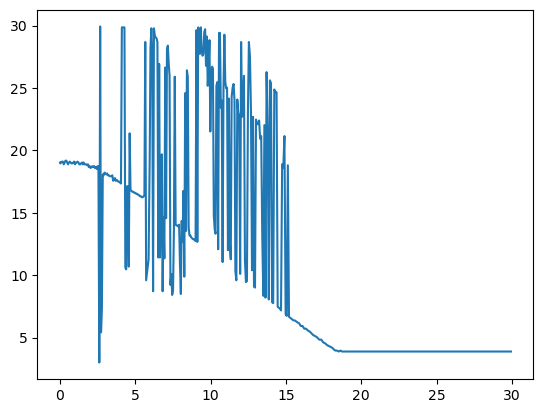

In [302]:
to_save = [date_time_obj, position]
np.save('Data/' + '1.npy', to_save)
a = np.load('Data/' + '1.npy')
plt.plot(a[0], a[1])

In [217]:
file = open(names[6], 'rb')
data_raw = pickle.load(file)
file.close()

In [218]:
data_single_chn = data_single_chn = data_raw['Data'][:,:,0]

In [219]:
n_frame = data_single_chn.shape[1]
position = np.zeros(n_frame)

In [220]:
for i in range(n_frame):
    data_snapshot = data_single_chn[:,i]
    data = np.reshape(data_snapshot, (N, frmMeasSiz), order='F')
    RP = 2 * np.fft.fft(np.multiply(data, Win2D), n=NFFT, axis=0) / ScaWin * 0.498 / 65536
    RPExt = RP[RMinIdx:RMaxIdx, :]
    RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=NFFTVel, axis=1) / ScaWinVel
    RD = RD[:,15:-15]
    RD_diff = np.abs(RD) - np.min(np.abs(RD))
    RD_norm = RD_diff / np.max(np.abs(RD))
    position[i] = get_position(RD_norm)

In [244]:
from datetime import datetime
data_raw['dtime'][6][:-9]
date_time_obj = []
flag = True
for i in range(len(data_raw['dtime'])):
    date = data_raw['dtime'][i]
    while(len(date) < 23):
        pre = date[:20]
        post = date[20:]
        date = pre+'0'+post
#     if len(date) == ' ':
#         pre = date[:-3]
#         post = date[-3:-1]
#         date = pre+'0'+post
#         if date[-1] == ' ':
#             pre = date[:-3]
#             post = date[-3:-1]
#             date = pre+'0'+post
    if flag:
        time_init = datetime.strptime(date, '%Y-%m-%d %H:%M:%S:%f')
        date_time_obj.append(0)
        flag = False
    else:
        delta = datetime.strptime(date, '%Y-%m-%d %H:%M:%S:%f') - time_init
        date_time_obj.append(delta.total_seconds())

Text(0, 0.5, 'range (m)')

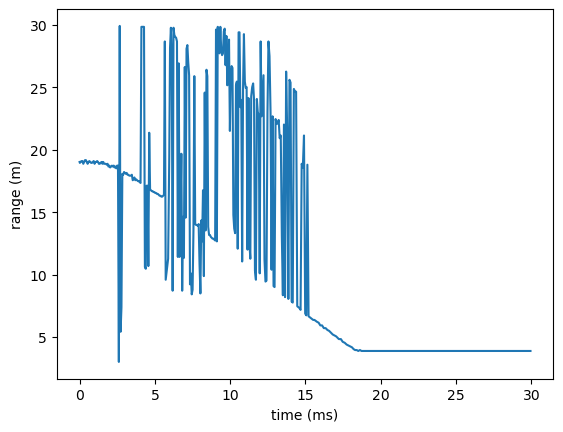

In [243]:
fig = plt.figure()
i = '1'
plt.plot(date_time_obj, position)
plt.xlabel('time (ms)')
plt.ylabel('range (m)')
# plt.savefig('plots/'+i+'.png')

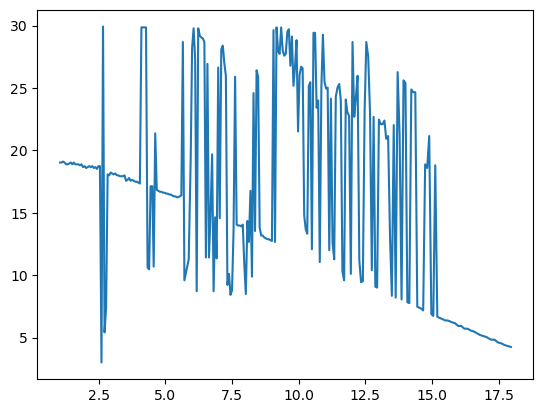

In [261]:
time_cut = np.array(date_time_obj)
position_cut = position[np.logical_and(time_cut>1, time_cut < 18)]
time_cut = time_cut[np.logical_and(time_cut>1, time_cut < 18)]
plt.plot(time_cut, position_cut)

In [262]:
class KalmanFilter(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt
        self.u = u
        self.std_acc = std_acc
        self.A = np.matrix([[1, self.dt],
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) 
        self.H = np.matrix([[1,0]])
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1])
        self.x = np.matrix([[0],[0]])
    def predict(self):
        # Ref :Eq.(9) and Eq.(10)
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x
    def update(self, z):
        # Ref :Eq.(11) , Eq.(11) and Eq.(13)
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Eq.(11)
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  # Eq.(12)
        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P  # Eq.(13)

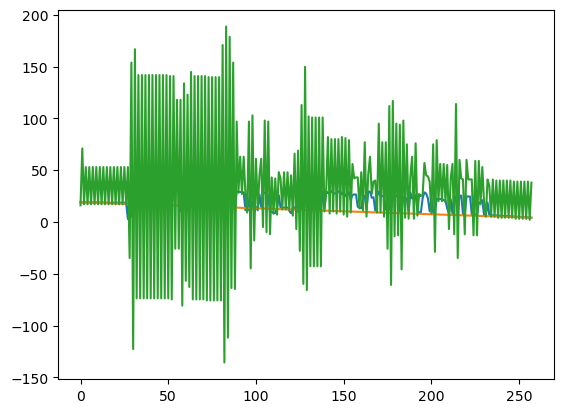

In [294]:
dt = time_cut[-1] - time_cut[0] / len(time_cut)
t = time_cut
real_track = np.linspace(position_cut[0], position_cut[-1], len(t))
u= 0.1
std_acc = 0.1     # we assume that the standard deviation of the acceleration is 0.25 (m/s^2)
std_meas = 0.25    # and standard deviation of the measurement is 1.2 (m)
kf = KalmanFilter(dt, u, std_acc, std_meas)
predictions = []
measurements = position_cut
for x in range(len(real_track)):
    # Mesurement
    predictions.append(kf.predict()[0])
    kf.update(measurements[x])
plt.plot(measurements)
plt.plot(real_track)
predictions = np.array(predictions)
plt.plot(predictions[:,0,0])

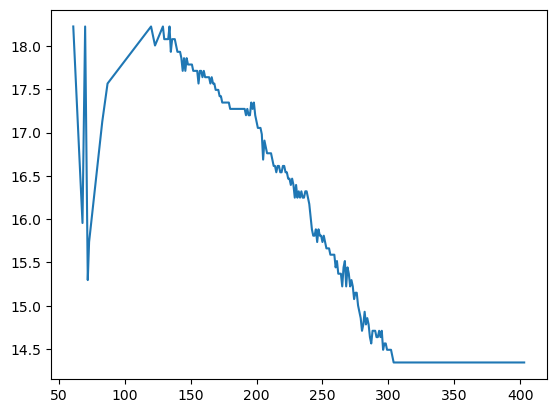

In [127]:
dt = 0.1
t = np.arange(0, 100, dt)
# Define a model track
real_track = 0.1*((t**2) - t)
u= 2
std_acc = 0.25     # we assume that the standard deviation of the acceleration is 0.25 (m/s^2)
std_meas = 1.2    # and standard deviation of the measurement is 1.2 (m)
# create KalmanFilter object
kf = KalmanFilter(dt, u, std_acc, std_meas)
predictions = []
measurements = []
for x in real_track:
    # Mesurement
    z = kf.H * x + np.random.normal(0, 50)
    measurements.append(z.item(0))
    predictions.append(kf.predict()[0])
    kf.update(z.item(0))

In [577]:
def detect_outlier_position_by_fft(signal, threshold_freq=0.1,
                                   frequency_amplitude=.001):
    signal = signal.copy()
    fft_of_signal = np.fft.fft(signal)
    outlier = np.max(signal) if abs(np.max(signal)) > abs(np.min(signal)) else np.min(signal)
    if np.any(np.abs(fft_of_signal[threshold_freq:]) > frequency_amplitude):
        index_of_outlier = np.where(signal == outlier)
        return index_of_outlier[0]
    else:
        return None

In [578]:
outlier_idx = []

y = position

opt = dict(threshold_freq=0.01, frequency_amplitude=0.001)

win = 20
for k in range(win*2, y.size, win):
    idx = detect_outlier_position_by_fft(y[k-win:k+win], **opt)
    if idx is not None:
        outlier_idx.append(k + idx[0] - win)
outlier_idx = list(set(outlier_idx))

TypeError: slice indices must be integers or None or have an __index__ method